# **CNN 모델**

# **라이브러리**

In [167]:
import pandas as pd
import numpy as np
import json
from konlpy.tag import Okt
okt=Okt()
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# import torch

# **데이터**

## **데이터 로드**

### **실행 안해두 됨**

In [168]:
## json으로 읽는 경우
with open('./data/final2_intent_example(187).json', 'r', encoding="utf-8") as f:
    json_data = json.load(f)
# intent_list 생성
B = pd.read_csv("./data/final2_title_node(187개).csv", encoding='utf-8')
intent_list = list(B["title"])
# intent_dic 생성
intent_dic = {}
for i,x in enumerate(intent_list):
    intent_dic[x] = i
print(len(intent_dic))
#! example_list 에서 중복되는 것들을 제거하자
df = pd.DataFrame(columns=["intent","examples"])
for x in json_data:
    if x in intent_list:
        for y in json_data[x]:
            df.loc[len(df)] = [x,y]
intent = df[['examples', 'intent']]
intent.columns = ['example', 'label']
intent

187


,example,label
0,끝,그만
1,갈게,그만
2,갈께,그만
3,그만,그만
4,닫기,그만
...,...,...
11957,이미 회원이라서요,이미회원인경우
11958,이미 회원가입해서요,이미회원인경우
11959,벌써 회원인데 어떻게 하지?,이미회원인경우
11960,이미 회원인데 어떻게 하지?,이미회원인경우


intent **label**당 적어도 3개는 필요하다

In [169]:
for l in intent.label.unique():
    l_len = len(intent[intent['label'] == l])
    if l_len < 15:
        print(l, l_len)

임박상품 10
증시 10
시사상식 13
아직인증못했어요 10


다행히 모두 3개 이상있음

In [170]:
intent_train, intent_etc, label_train, label_etc = train_test_split(intent['example'], intent['label'], test_size=0.2, stratify=intent['label'])

intent_valid, intent_test, label_valid, label_test = train_test_split(intent_etc, label_etc, test_size=0.5, stratify=label_etc)

# Series(intent+label)를 합쳐 Dataframe으로
train_data = pd.concat([intent_train, label_train], axis=1)
valid_data = pd.concat([intent_valid, label_valid], axis=1)
test_data = pd.concat([intent_test, label_test], axis=1)

train_data.to_csv('final_train.csv', index=False, encoding='utf-8-sig')
valid_data.to_csv('final_varlid.csv', index=False, encoding='utf-8-sig')
test_data.to_csv('final_test.csv', index=False, encoding='utf-8-sig')

print(len(train_data))
print(len(valid_data))
print(len(test_data))

9569
1196
1197


### **최종 확인 데이터**

In [200]:
train_data = pd.read_csv('./data/final2_train2.csv')
valid_data = pd.read_csv('./data/final2_valid2.csv')
test_data = pd.read_csv('./data/final2_test2.csv')

In [201]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

print(train_data.label.nunique())
print(valid_data.label.nunique())
print(test_data.label.nunique())

8959
1881
1122
187
187
187


## **중복/결측값 확인**

In [202]:
dup = train_data.duplicated(['example'], keep=False)
df_dup = pd.concat([train_data, dup], axis=1)
df_dup.rename(columns = {0 : 'Dup'}, inplace=True)
df_dup[df_dup['Dup']==True]

,example,label,Dup


In [203]:
print('Null값 존재 확인:', train_data.isnull().values.any())
print('고유값들의 수(intent, label):', train_data['example'].nunique(), train_data['label'].nunique())
train_data.drop_duplicates(subset=['example'], inplace=True)
train_data

Null값 존재 확인: False
고유값들의 수(intent, label): 8959 187


,example,label
0,잘가,그만
1,bye,그만
2,상담 종료,그만
3,끝,그만
4,잘자요,그만
...,...,...
8954,이미 회원인데 어떻게 하지?,이미회원인경우
8955,이미 회원가입해서요,이미회원인경우
8956,벌써 가입했어요,이미회원인경우
8957,벌써 가입했거든요,이미회원인경우


## **토큰화**

In [204]:
stopwords = []
X_train_token = []
for sentence in train_data['example']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_train_token.append(temp_X)

X_test_token = []
for sentence in test_data['example']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_test_token.append(temp_X)

X_valid_token = []
for sentence in valid_data['example']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_valid_token.append(temp_X)

print(X_train_token[0], len(X_train_token[0]))

In [332]:
X_train_token[14]


['갈다', '즐겁다']

In [205]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_token)
tokenizer.word_index

# 불용어 사전 등록을 위해 단어 빈도수 체크
word_count_dic = list(sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True))[:100]
word_count_dic

[('하다', 3941),
 ('?', 2450),
 ('어떻다', 1809),
 ('되다', 1635),
 ('알다', 1503),
 ('있다', 1308),
 ('이', 1222),
 ('상품', 1135),
 ('배송', 933),
 ('제품', 896),
 ('수', 890),
 ('주문', 840),
 ('은', 702),
 ('문의', 658),
 ('해주다', 638),
 ('반품', 612),
 ('가', 610),
 ('에', 593),
 ('방법', 585),
 ('결제', 561),
 ('궁금하다', 542),
 ('동원', 541),
 ('계산서', 532),
 ('세금', 531),
 ('받다', 525),
 ('으로', 495),
 ('를', 486),
 ('을', 463),
 ('현금영수증', 460),
 ('회원', 437),
 ('확인', 434),
 ('몰다', 433),
 ('싶다', 428),
 ('가능하다', 421),
 ('안내', 388),
 ('는', 376),
 ('뭐', 366),
 ('쿠폰', 359),
 ('언제', 354),
 ('가입', 350),
 ('건지다', 344),
 ('교환', 332),
 ('하고', 322),
 ('한', 321),
 ('발송', 299),
 ('적립금', 294),
 ('취소', 290),
 ('완료', 283),
 ('내', 283),
 ('발급', 280),
 ('문자', 269),
 ('원', 265),
 ('요', 261),
 ('비회', 253),
 ('구매', 252),
 ('만', 251),
 ('신청', 249),
 ('로', 247),
 ('왜', 242),
 ('중', 236),
 ('어디서', 228),
 ('알', 227),
 ('고', 216),
 ('일자', 208),
 ('가격', 206),
 ('후', 194),
 ('다시', 190),
 ('경우', 184),
 ('지', 183),
 ('대해', 182),
 ('탈퇴', 180),
 ('역', 

In [206]:
for i in list(sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)):
    if i[1] < 3:
        print(i[0])

종료
계시다
담
만나다
갈다
즐겁다
굳다
good
어휴
우롱
한심하다
치다
모야
음
님들
및
기대하다
휴
헛소리
제대로
링
쇼
1:1
이렇게
그래서
헤헤
ㅋㅋ
호호
해봤다
죄송하다
착하다
렴
발전
굿
~~~
나쁘다
울적하다
재다
엉
믿다
사도
글쿤
글
ㅇ
고장
5천원
지우다
달랑
기프티콘
이미지
라서
등업
산정
맴버십
에게
멤버십
안보
참여
달다
처음
아무
(
누르다
내야
서포터즈
생
국밥
*
우유
붙다
이전
일괄
공지
[
/
]
전혀
제주
ㅠ
1일
스프
연어
될런
모으다
놓다
3500원
이라는
중인
주니
보상
품평
알아보다
상황
세다
예요
cs
일해
일방
많다
우
물류
당장
에게로
체크
즉시
대신
란
깨다
녹다
신고
함
어딘가
카카오
반값특
오픈
마
일드
김
검다
보이지
먼저
왜안
따로
안해
송부
쌀
본인
오스
정상
화면
화
적립
내일
수입
가기
임직
가나
10월
가보다
집사
정원
샵
가깝다
url
홈피
특징
어플
수가
오뚜기
벌다
가성
코코
꺼
고추
왕새우
파
깍두기
잘나가다
가전제품
사무
전자제품
견과류
과일
신선
가슴
보조
영
양제
티슈
휴지
미용
얘기
웃기다
증시
인가
다니다
배다
27
애
이썽
모
워
싸랑
love
지루하다
자고
졸렵다
이루어지다
황사
소형
크리미
슈
츄어블
전보
내려가다
코
재주
일치
불가능
용하다
안내받다
추가
조치
이고
내놓다
스모크
향
씨리얼
갖다
청해
요망
이라
화일
구분
차이점
거치다
끼리
따로따로
아이스박스
어떤
옴
보통
다음
수량
9
봉지
히비스커스
알약
공기청정기
훈제
통닭
8
다리
공액
리놀레산
팻
사이즈
피부
가려움
효과
귤
상자
정품
블랙
에디
션
알루미늄
실속
견적
오래되다
두다
사가
환경
호르몬
환경호르몬
위험하다
즉석밥
가짜
생선
주의
동도
bye
빠염
나중
닫다
바이바이
계세
바이
마치다
굿바이
꺼지다
see
again
by
아이고
업그레이드
도움
앙망
장난
어이없다
저런
멍충
성장하다
악
구려
ㅠㅜ
말귀
알아듣다
구리
소릴
자빠지다
멍청이
때매
이해도
엉망
구조
개선
증대
그것
죄악
쯔쯔
수준
상당하다


In [207]:
# 등장 빈도수가 3회 미만인 단어들의 비중 확인
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0    # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0   # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('vocabulary 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt / total_cnt)*100)
print("단어 집합에서 희귀 단어의 비율:", (rare_freq / total_freq)*100)

vocabulary 크기 : 1946
등장 빈도가 1번 이하인 희귀 단어 수: 791
단어 집합에서 희귀 단어의 비율: 40.647482014388494
단어 집합에서 희귀 단어의 비율: 1.2381817043391146


In [210]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

tokenizer = Tokenizer(vocab_size, oov_token = "<OOV>")
tokenizer.fit_on_texts(X_train_token)

X_train = tokenizer.texts_to_sequences(X_train_token)
X_valid = tokenizer.texts_to_sequences(X_valid_token)
X_test = tokenizer.texts_to_sequences(X_test_token)

단어 집합의 크기 : 1156


In [211]:
y_train = np.array(train_data['label'])
y_valid = np.array(valid_data['label'])
y_test = np.array(test_data['label'])

In [212]:
print(len(X_train))
print(len(y_train))

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

8959
8959
8959
8959


c:\Anaconda3\envs\chatbot_1\lib\site-packages\numpy\lib\function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [213]:
# 레이블 인코딩. 레이블에 고유한 정수를 부여
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(y_train)

y_train = idx_encode.transform(y_train) # 주어진 고유한 정수로 변환
y_valid = idx_encode.transform(y_valid) # 고유한 정수로 변환
y_test = idx_encode.transform(y_test) # 고유한 정수로 변환

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print('레이블과 정수의 맵핑 관계 :',label_idx)

# 추론에 쓰일 Dict
reverse_label_idx = {v:k for k,v in label_idx.items()} #// {'AA': '0', 'BB': '1', 'CC': '2'}

레이블과 정수의 맵핑 관계 : {'GNC선물세트특판': 0, '감사': 1, '결제방법변경': 2, '결제방법안내': 3, '결제지연경우안내': 4, '고객기분나쁨': 5, '고객기분좋음': 6, '고객만족센터연락처': 7, '고객만족센터운영시간': 8, '고객만족센터전화불통': 9, '공인인증서의무사용안내': 10, '교환요청': 11, '교환정책': 12, '교환회수날짜지정': 13, '그만': 14, '김치상품안내': 15, '날짜및시간': 16, '노래': 17, '농담': 18, '다른상품교환': 19, '당첨경품배송': 20, '대량주문안내': 21, '대표이사안내': 22, '도서산간지역배송': 23, '동원몰강점': 24, '동원몰매출': 25, '동원몰베스트상품소개': 26, '동원몰상품문의': 27, '동원몰소개': 28, '동원몰앱안내': 29, '동원몰홈페이지': 30, '동원몰회원제': 31, '동원브랜드및상품소개': 32, '동원선물세트특판': 33, '동원소개': 34, '동원입사': 35, '동원참치원산지': 36, '동원천지인백수오사용': 37, '동원홈페이지': 38, '레시피등록': 39, '로그인방법': 40, '리챔내용물쉽게꺼내는방법': 41, '리챔상품안내': 42, '만두상품안내': 43, '모바일쿠폰문의': 44, '무료배송안내': 45, '무이자신용카드': 46, '묶음배송': 47, '문의내역확인': 48, '뭐먹었어': 49, '뭐해': 50, '반품배송비안내': 51, '반품요청': 52, '반품절차': 53, '반품주소문의': 54, '받을수있는쿠폰안내': 55, '발행종류': 56, '배송기간안내': 57, '배송누락': 58, '배송비부담기준안내': 59, '배송일지정불가안내': 60, '배송정책': 61, '밴드배송안내': 62, '비회원반품': 63, '비회원배송확인': 64, '비회원주문': 65, '사과': 66, '사랑해': 67, '상품QA수정': 68, '상품가격차이': 69, '상품문의': 

In [214]:
import matplotlib.pyplot as plt

print('리뷰의 최대 길이 : ',max(len(l) for l in X_train))
print('리뷰의 평균 길이 : ',sum(map(len, X_train))/len(X_train))
print('리뷰의 최대 길이 : ',max(len(l) for l in X_valid))
print('리뷰의 평균 길이 : ',sum(map(len, X_valid))/len(X_valid))
print('리뷰의 최대 길이 : ',max(len(l) for l in X_test))
print('리뷰의 평균 길이 : ',sum(map(len, X_test))/len(X_test))
# plt.hist([len(s) for s in X_train], bins=50)
# plt.xlabel('length of samples')
# plt.ylabel('number of samples')
# plt.show()

리뷰의 최대 길이 :  82
리뷰의 평균 길이 :  7.130706552070544
리뷰의 최대 길이 :  43
리뷰의 평균 길이 :  7.028176501860712
리뷰의 최대 길이 :  36
리뷰의 평균 길이 :  6.266488413547237


In [215]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 82
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 82 이하인 샘플의 비율: 100.0


## **패딩**

In [216]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_valid = pad_sequences(X_valid, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# y_train = to_categorical(y_train)
# y_valid = to_categorical(y_valid)
# y_test = to_categorical(y_test)

print(X_train[0])
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 165]
(8959, 82)
(1881, 82)
(1122, 82)


# **학습**

In [217]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.models import load_model

In [218]:
embedding_dim = 128
hidden_units = 128
num_classes = 187
epoch = 100

cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 3. 모델 학습과정 설정하기
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = cnn_model.fit(X_train, y_train, epochs=100, batch_size=64, callbacks=[es, mc], validation_data=(X_valid, y_valid))

Epoch 1/100
140/140 [==============================] - 1s 7ms/step - loss: 4.2443 - accuracy: 0.1751 - val_loss: 2.7376 - val_accuracy: 0.4928
Epoch 2/100
140/140 [==============================] - 1s 4ms/step - loss: 1.7897 - accuracy: 0.6401 - val_loss: 1.2457 - val_accuracy: 0.7459
Epoch 3/100
140/140 [==============================] - 1s 4ms/step - loss: 0.9317 - accuracy: 0.7942 - val_loss: 0.7741 - val_accuracy: 0.8283
Epoch 4/100
140/140 [==============================] - 1s 4ms/step - loss: 0.5734 - accuracy: 0.8644 - val_loss: 0.5641 - val_accuracy: 0.8713
Epoch 5/100
140/140 [==============================] - 1s 4ms/step - loss: 0.3821 - accuracy: 0.9047 - val_loss: 0.4438 - val_accuracy: 0.8969
Epoch 6/100
140/140 [==============================] - 1s 4ms/step - loss: 0.2668 - accuracy: 0.9322 - val_loss: 0.3901 - val_accuracy: 0.9096
Epoch 7/100
140/140 [==============================] - 1s 4ms/step - loss: 0.2007 - accuracy: 0.9482 - val_loss: 0.3518 - val_accuracy: 0.9208

In [219]:
cnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 82, 128)           147968    
                                                                 
 dropout_18 (Dropout)        (None, 82, 128)           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 80, 256)           98560     
                                                                 
 global_max_pooling1d_9 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                      

{'loss': [4.244255542755127, 1.789655327796936, 0.9316893219947815, 0.5734090805053711, 0.3820757269859314, 0.2667783200740814, 0.20071420073509216, 0.1541367769241333, 0.12191604822874069, 0.10420669615268707, 0.08104830235242844, 0.07828260213136673, 0.06542637199163437], 'accuracy': [0.175131157040596, 0.6401383876800537, 0.7941734790802002, 0.8643822073936462, 0.9046768546104431, 0.9322469234466553, 0.9482085108757019, 0.9594820737838745, 0.9681884050369263, 0.9723183512687683, 0.9781225323677063, 0.9778993129730225, 0.9833686947822571], 'val_loss': [2.7376208305358887, 1.2457259893417358, 0.7740561962127686, 0.5641050934791565, 0.44380053877830505, 0.3901083171367645, 0.3517797291278839, 0.3400634229183197, 0.3347984254360199, 0.3289446532726288, 0.3424258828163147, 0.3460977077484131, 0.3515627682209015], 'val_accuracy': [0.4928229749202728, 0.7458798289299011, 0.8282828330993652, 0.871345043182373, 0.8968633413314819, 0.9096225500106812, 0.9207867980003357, 0.9218500852584839, 0

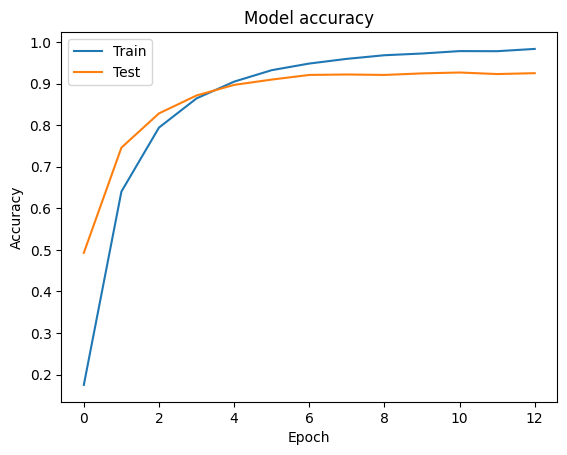

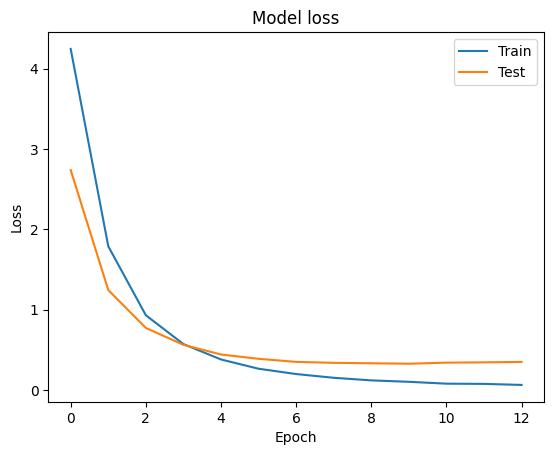

In [220]:
print(hist.history)

# 훈련 과정 시각화 (정확도)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 훈련 과정 시각화 (손실)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# **평가**

In [223]:
# 모델 평가(테스트 데이터셋 이용)
loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy * 100))
print('loss: %f' % (loss))

# 모델 저장
cnn_model.save('cnn_model.h5')

36/36 [==============================] - 0s 5ms/step - loss: 0.7055 - accuracy: 0.8422
Accuracy: 84.224600
loss: 0.705538


# **추론(Inference)**

In [321]:
def intentClassification(text):
    new_sentence = okt.morphs(text, stem=True)
    print(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]
    print(new_sentence)
    encoded = tokenizer.texts_to_sequences([new_sentence])
    # print(encoded)
    pad_new = pad_sequences(encoded, maxlen = max_len)
    print(pad_new)
    score = cnn_model.predict(pad_new)
    # print(len(score))

    return reverse_label_idx.get(np.argmax(score))

In [322]:
intentClassification(input())

['어떻다', '하다', '교환', '하다', '수', '있다']
['어떻다', '하다', '교환', '하다', '수', '있다']
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  4  2 43  2 12  7]]
1/1 [==============================] - 0s 12ms/step


'교환요청'

# **ETC**

In [ ]:
from sklearn.metrics import classification_report

predictions = cnn_model.predict(X_test)

# print("y_test: ", y_test[45::55])
# print("predictions: ", np.argmax(predictions[45::55], axis=1))

print("y_test: ", y_test)
print("predictions: ", np.argmax(predictions, axis=1))

report_result = classification_report(y_test, np.argmax(predictions, axis=1))


In [325]:
print(report_result)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.42      0.83      0.56         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      0.67      0.80         6
           6       1.00      0.33      0.50         6
           7       0.86      1.00      0.92         6
           8       1.00      1.00      1.00         6
           9       1.00      0.83      0.91         6
          10       1.00      1.00      1.00         6
          11       1.00      0.83      0.91         6
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       0.33      0.33      0.33         6
          15       1.00      0.17      0.29         6
          16       0.86      1.00      0.92         6
          17       1.00    